# Tutorial - Transformers

In [1]:
#|all_slow

In this tutorial, we will see how we can use the fastai library to fine-tune a pretrained transformer model from the [transformers library](https://github.com/huggingface/transformers) by HuggingFace. We will use the mid-level API to gather the data. Even if this tutorial is self contained, it might help to check the [imagenette tutorial](http://docs.fast.ai/tutorial.imagenette) to have a second look on the mid-level API (with a gentle introduction using the higher level APIs) in computer vision.

## Importing a transformers pretrained model

In [2]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

We can use several versions of this GPT2 model, look at the [transformers documentation](https://huggingface.co/transformers/pretrained_models.html) for more details.

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [4]:
ids = tokenizer.encode('This is an example of text, and')
ids

[1212, 318, 281, 1672, 286, 2420, 11, 290]

In [5]:
tokenizer.decode(ids)

'This is an example of text, and'

The model can be used to generate predictions (it is pretrained). It has a `generate` method that expects a batch of prompt, so we feed it our ids and add one batch dimension (there is a padding warning we can ignore as well):

In [6]:
import torch

In [7]:
t = torch.LongTensor(ids)[None]
preds = model.generate(t)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The predictions, by default, are of length 20:

In [8]:
preds.shape,preds[0]

(torch.Size([1, 20]),
 tensor([1212,  318,  281, 1672,  286, 2420,   11,  290,  340,  338,  407,  257,
          922,  530,   13,  198,  198,  464,  717, 1517]))

We can use the decode method (that prefers a numpy array to a tensor):

In [9]:
tokenizer.decode(preds[0].numpy())

"This is an example of text, and it's not a good one.\n\nThe first thing"

## Bridging the gap with fastai

In [10]:
from fastai.text.all import *

### Preparing the data

Then we download the dataset (if not present), it comes as two csv files:

In [11]:
path = untar_data(URLs.WIKITEXT_TINY)
path.ls()

(#2) [Path('C:/Users/ethan/.fastai/data/wikitext-2/test.csv'),Path('C:/Users/ethan/.fastai/data/wikitext-2/train.csv')]

In [12]:
df_train = pd.read_csv(path/'train.csv', header=None)
df_valid = pd.read_csv(path/'test.csv', header=None)
df_train.head()

,0
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z..."
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re..."
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit..."
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch..."
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ...."


In [13]:
all_texts = np.concatenate([df_train[0].values, df_valid[0].values])

In [14]:
import pandas

In [15]:
full_df = pandas.read_excel("gatherCatalogTexts_Aug22.xlsx")

In [16]:
I = full_df.is_resume==2
#display(full_df[I].head())
full_df = full_df[I]

In [17]:
from sklearn.model_selection import train_test_split
df_train, df_valid= train_test_split(full_df, test_size=0.33, random_state=42)

In [18]:
all_texts = np.concatenate([df_train['text_content'].values, df_valid['text_content'].values])

In a fastai `Transform` you can define:
- an <code>encodes</code> method that is applied when you call the transform (a bit like the `forward` method in a `nn.Module`)
- a <code>decodes</code> method that is applied when you call the `decode` method of the transform, if you need to decode anything for showing purposes (like converting ids to a text here)
- a <code>setups</code> method that sets some inner state of the `Transform` (not needed here so we skip it)

In [19]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

- in <code>decodes</code> we return a `TitledStr` object and not just a plain string. That's a fastai class that adds a `show` method to the string, which will allow us to use all the fastai show methods.

You can then group your data with this `Transform` using a `TfmdLists`. It has an s in its name because it contains the training and validation set. We indicate the indices of the training set and the validation set with `splits` (here all the first indices until `len(df_train)` and then all the remaining indices):

In [20]:
splits = [range_of(df_train), list(range(len(df_train), len(all_texts)))]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

Token indices sequence length is longer than the specified maximum sequence length for this model (1674 > 1024). Running this sequence through the model will result in indexing errors


In [21]:
tls.train[0],tls.valid[0]

(tensor([628, 628, 628,  ..., 220, 628, 198]),
 tensor([  628,   628,   628,   628,   628,   628,   628,   628,   628,   628,
           628,   628,   628,   628,   628,   628,   628,   628,   628,   628,
           628,   628,   628,   628,   628,   628,   628,   628,   628,   628,
           198,  8743,    62,  9527,  2304,    84,    62,  4965,  2454,    62,
          5539,    13, 31126,   628,   198, 17121,  2574,  2304,    84,   930,
         24278, 42242,  1581, 10239,  5984,    38, 10714, 10460,   198, 32637,
           930,   767,  6420,   860, 44218,   220,   220,   220,   220,   220,
           220,   220,   220,   198,    43, 31166, 26124,    31,  1326,    13,
           785,   220,   220,   220,   220,   220,   220,   220,   198,   198,
         43559,  3180,  1294,   220,   357, 18960,   352,   930,  1596,  4551,
          8052,     8,   220,   220,   220,   220,  3683,  5890,   220,   220,
           350,    13,    35,    13, 10936,  1305,   315,    74,  2364,   198,
     

In [22]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([1674]), torch.Size([990]))

And we can have a look at both decodes using `show_at`:

In [23]:
show_at(tls.train, 0)













































Microsoft Word - William(Bill)Varney resume.doc


William (Bill) Varney  
   

4 0 7  W H I TN E Y  S TR E T,  FRED ER ICKSBU RG,  T EXAS  7 8 6 2 4  

  Telephone 
  830.456.9667 
 

  Email   
  William@WilliamVarney.com 

Profile 
Strongly experienced in business and management with over 25 years in the restaurant, hospitality, and 
in the commercial herb production and distribution industry as the highly successful founder and previ-
ous owner of nationally acclaimed Fredericksburg Herb Farm. Achievement oriented with demonstrated 
leadership ability and creative problem solver to enable rapid growth within organizations.  Eager to uti-
lize a goal-oriented, ethical and energetic approach to deliver high quality client service, products and 
results. Areas of expertise include:  consultative and solutions selling, retail, wholesale and mail orders 
expertise, artisan, innovator, regarded as one American’s foremost experts on the use of he

In [24]:
show_at(tls.valid, 0)






























































Will_Eliscu_Resume_2017.pages


William Eliscu | ART DIRECTOR Member ADG Local 800
323 | 791 9554        
Lsqdesign@me.com       

THIS IS US  (Season 1 | 17 Episodes)     Art Director   P.D. Gary Frutkoff
(FOX Television)

THE NIGHT SHIFT (Seasons 4 | 10 Episodes)     Art Director   P.D. Anthony Medina  
(Sony Pictures)

Television Credits (partial list):

SHAMELESS (Seasons 9 | Episodes 18 & 19)     Art Director   P.D. Nina Ruscio  
(WarnerBros)

DIRTY JOHN (Seasons 2)    Art Director   P.D. Jeff Mossa
(Universal Content Productions)

CHICAGO P.D. (Seasons 1-3 | 61 Episodes)   Art Director   P.D. Greg Van Horn
(NBCUniversal)
SONS OF ANARCHY (Season 2) Assistant Art Dir. P.D. Anthony Medina
(Fox)
GLEE (Season 1) Assistant Art Dir. P.D. Mark Hutman
(Fox) 
PARKS & RECREATION Graphic Designer   P.D. Ian Philips
(NBCUniversal)

Motion Picture Credits (partial list):

BLACK HAT Lead Graphic Designer Dir. Michael Mann
(Legendary P

The fastai library expects the data to be assembled in a `DataLoaders` object (something that has a training and validation dataloader).

In [25]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Note that you may have to reduce the batch size depending on your GPU RAM.

In [26]:
dls.show_batch(max_n=2)

C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({labe

,text,text_
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n James Person \n\nRockingham, VA 22801 ⎜555.555.5555 ⎜sample@dukes.jmu.edu \n \n\n \nSUMMARY: \n\n 6 years management experience including staff supervision, communication with senior personnel, high stress \nmultitasking environments, troubleshooting electronic systems \n\n Interest in Geographic Information Systems, Natural Resource Management, Urban Planning \n\n Proficient in ArcGIS, R Statistical Software, GPS, interpersonal communication, staff supervision, \nquality assurance \n\nEDUCATION: \nJames Madison University, Harrisonburg, Virginia Expected May 2019 \n\nB","\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n James Person \n\nRockingham, VA 22801 ⎜555.555.5555 ⎜sample@dukes.jmu.edu \n \n\n \nSUMMARY: \n\n 6 years management experience including staff supervision, communication with senior personnel, high stress \nmultitasking environments, troubleshooting electronic systems \n\n Interest in Geographic Information Systems, Natural Resource Management, Urban Planning \n\n Proficient in ArcGIS, R Statistical Software, GPS, interpersonal communication, staff supervision, \nquality assurance \n\nEDUCATION: \nJames Madison University, Harrisonburg, Virginia Expected May 2019 \n\nBachelor"
1,"Y.-S., Matthews, P.G. & Hubbard, E.M. \n(2018, March). Neurocognitive relationships between nonsymbolic and symbolic ratio \nprocessing in children and adults. Poster presented at the Cognitive Neuroscience Society \nMeeting, Boston, MA. \n\nKalish, C. W., Meng, R, Seng, A. & Matthews P. G. (2017, July). Optimizing mathematics learning \nEffects of continuous and nominal practice format on transfer of arithmetic skills. Poster \npresented at the 39th Annual Conference of the Cognitive Science Society. London, UK. \n\nMeng, R. & Matthews, P. G. (2017, July). Presentation format modulates adults’ automatic processing \nof proportions. Poster presented at the 39th Annual Conference of the Cognitive Science \nSociety. London, UK. \n\nHubbard, E. M., Binzak, J. V. & Matthews, P. G. (2017, July). Grounding fractions in the RPS: \nCommon distance effects for symbolic fractions and non-symbolic ratios suggest shared \nprocessing. Talk presented at the 5th annual Midwest Meeting on Mathemat",".-S., Matthews, P.G. & Hubbard, E.M. \n(2018, March). Neurocognitive relationships between nonsymbolic and symbolic ratio \nprocessing in children and adults. Poster presented at the Cognitive Neuroscience Society \nMeeting, Boston, MA. \n\nKalish, C. W., Meng, R, Seng, A. & Matthews P. G. (2017, July). Optimizing mathematics learning \nEffects of continuous and nominal practice format on transfer of arithmetic skills. Poster \npresented at the 39th Annual Conference of the Cognitive Science Society. London, UK. \n\nMeng, R. & Matthews, P. G. (2017, July). Presentation format modulates adults’ automatic processing \nof proportions. Poster presented at the 39th Annual Conference of the Cognitive Science \nSociety. London, UK. \n\nHubbard, E. M., Binzak, J. V. & Matthews, P. G. (2017, July). Grounding fractions in the RPS: \nCommon distance effects for symbolic fractions and non-symbolic ratios suggest shared \nprocessing. Talk presented at the 5th annual Midwest Meeting on Mathematical"


Another way to gather the data is to preprocess the texts once and for all and only use the transform to decode the tensors to texts:

In [27]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

Now we change the previous `Tokenizer` like this:

In [28]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In the <code>encodes</code> method, we still account for the case where we get something that's not already tokenized, just in case we were to build a dataset with new texts using this transform.

In [29]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [30]:
dls.show_batch(max_n=2)

C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
C:\Users\ethan\Downloads\anaconda\lib\site-packages\fastai\torch_core.py:500: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({labe

,text,text_
0,"\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMicrosoft Word - 2022J+C-Resume.doc\n\n\n 1 \n\nJugnet + Clairet \n \nAmerican artists, French born \n\nWork in multiple media. Live in New Mexico \n\n \n\nEducation, Professorships and Jury Appointments \n\nAnne Marie Jugnet \n\nb. May 25, 1958 - La Clayette, France \n\nM.A. (DNSEP Art), National Art School of Bourges,1981 \n\nProfessor, the Art School of Versailles, 1984-87 \n\nProfessor, the National Art School of Bourges,1985-1991 \n\nProfessor, the National Art School of Nancy, 1993-94 \n\nProfessor, the Architecture School of Saint-Etienne, 1994-2001 \n\nMember of the Jury of FIACRE (National Art Grants), French Ministry of Culture, 2000-03 \n\nVice-President of the Jury of the French Academy in Rome (Villa Medici), Italy, 2014 \n\nAlain Clairet \n\nb. July 7,","\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMicrosoft Word - 2022J+C-Resume.doc\n\n\n 1 \n\nJugnet + Clairet \n \nAmerican artists, French born \n\nWork in multiple media. Live in New Mexico \n\n \n\nEducation, Professorships and Jury Appointments \n\nAnne Marie Jugnet \n\nb. May 25, 1958 - La Clayette, France \n\nM.A. (DNSEP Art), National Art School of Bourges,1981 \n\nProfessor, the Art School of Versailles, 1984-87 \n\nProfessor, the National Art School of Bourges,1985-1991 \n\nProfessor, the National Art School of Nancy, 1993-94 \n\nProfessor, the Architecture School of Saint-Etienne, 1994-2001 \n\nMember of the Jury of FIACRE (National Art Grants), French Ministry of Culture, 2000-03 \n\nVice-President of the Jury of the French Academy in Rome (Villa Medici), Italy, 2014 \n\nAlain Clairet \n\nb. July 7, 1950"
1,", and \nA.V. Lun’kov, p. 633-635. Book of Scientific Papers, Publishing House, Irkustsk State Technical \nUniversity, Irkutsk. \n \nOetelaar, G.A. \n2003 Engaging Indigenous People and Archaeologists: Some Challenges. In Indigenous People \nand Archaeology: Honouring the Past, Discussing the Present, Building for the Future, edited by \nT.T. Peck, E. Siegfried, and G.A. Oetelaar, pp. 2-7. The Archaeological Association of the \nUniversity of Calgary, Calgary. \n \nOetelaar, G.A., R. Honsberger and B. Starlight \n2003 Looking to Yesterday, Building for Tomorrow: A Cooperative Venture between the \nUniversity of Calgary, Carma Developers Ltd, and the Tsuu t'ina Nation. In Archaeology into the \nNew Millenium: Public or Perish, edited by B Cripps, R. Dickau, L. Hartery, M. Lobb, D. \nMeyer, L. Nicholls, and T. Varney,","and \nA.V. Lun’kov, p. 633-635. Book of Scientific Papers, Publishing House, Irkustsk State Technical \nUniversity, Irkutsk. \n \nOetelaar, G.A. \n2003 Engaging Indigenous People and Archaeologists: Some Challenges. In Indigenous People \nand Archaeology: Honouring the Past, Discussing the Present, Building for the Future, edited by \nT.T. Peck, E. Siegfried, and G.A. Oetelaar, pp. 2-7. The Archaeological Association of the \nUniversity of Calgary, Calgary. \n \nOetelaar, G.A., R. Honsberger and B. Starlight \n2003 Looking to Yesterday, Building for Tomorrow: A Cooperative Venture between the \nUniversity of Calgary, Carma Developers Ltd, and the Tsuu t'ina Nation. In Archaeology into the \nNew Millenium: Public or Perish, edited by B Cripps, R. Dickau, L. Hartery, M. Lobb, D. \nMeyer, L. Nicholls, and T. Varney, pp"


### Fine-tuning the model

The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations (should we want to use them in some regularization scheme). To work inside the fastai training loop, we will need to drop those using a `Callback`: we use those to alter the behavior of the training loop.

In [31]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [32]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [32]:
learn.validate()

C:\Users\ethan\Downloads\anaconda\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\ethan\Downloads\anaconda\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [3.6523540019989014,38.56534194946289]

This lists the validation loss and metrics (so 26.6 as perplexity is kind of amazing).

SuggestedLRs(valley=0.00015848931798245758)

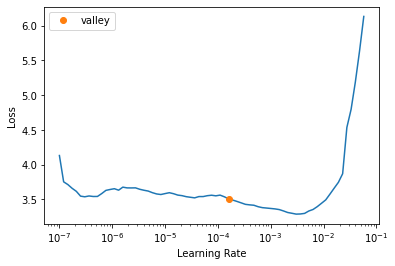

In [33]:
learn.lr_find()

The learning rate finder curve suggests picking something between 1e-4 and 1e-3.

In [33]:
learn.fit_one_cycle(1, 1e-4)

C:\Users\ethan\Downloads\anaconda\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\ethan\Downloads\anaconda\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,perplexity,time
0,2.921721,2.847275,17.240732,11:25:48


In [34]:
learn.save('resumes_classifier_transformers')

Path('models/resumes_classifier_transformers.pth')

In [35]:
df_valid.head(1)

,sample_id,record_id,local_filegroup,local_filestem,file_exts,text_language,filesize,textsize,num_pages,is_resume,text_content
1520,d002339,<urn:uuid:4fb5e1f1-339d-4d96-a8e0-bc232e2010bf>,d002,d002339,.pdf/.txt,en,262974,3014,1.0,2.0,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nWill_Eliscu_Resume_2017.pages\n\n\nWilliam Eliscu | ART DIRECTOR Member ADG Local 800\n323 | 791 9554 \nLsqdesign@me.com \n\nTHIS IS US (Season 1 | 17 Episodes) Art Director P.D. Gary Frutkoff\n(FOX Television)\n\nTHE NIGHT SHIFT (Seasons 4 | 10 Episodes) Art Director P.D. Anthony Medina \n(Sony Pictures)\n\nTelevision Credits (partial list):\n\nSHAMELESS (Seasons 9 | Episodes 18 & 19) Art Director P.D. Nina Ruscio \n(WarnerBros)\n\nDIR...


Article seems to begin with new line and the title between = signs, so we will mimic that:

In [64]:
prompt = "WORK/VOLUNTEERING Fasca — VolunteerJune 2021 - August 2021100 hours of community service: cleaning the TECRO building, assisting with weekly events, library assistance"

The prompt needs to be tokenized and numericalized, so we use the same function as before to do this, before we use the `generate` method of the model.

In [65]:
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
inp.shape

torch.Size([1, 37])

In [66]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=1.5)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [67]:
tokenizer.decode(preds[0].cpu().numpy())

'WORK/VOLUNTEERING Fasca — VolunteerJune 2021 - August 2021100 hours of community service: cleaning the TECRO building, assisting with weekly events, library assistance, and community outreach. \n                                                        '

In [71]:
preds = learn.predict(prompt_ids)

AssertionError: Expected an input of type in 
  - <class 'torch.Tensor'>
 but got <class 'list'>